# Model training notebook with wandb logging 

wandb description

In [1]:
description = "efficientnet pretrained True 20 epoch 1971 focal present, 1971 human labelled present and 3942 human labelled absent."

In [2]:
# !pip install wandb
# ! pip install wandb --upgrade

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [7]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, show_sample_from_df, clean_confidence_cats, get_recording_durations, plot_metrics_across_thresholds
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import glob
import sklearn
import ipywidgets as widgets

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"

# Log some hyperparameters

In [9]:
n_samples_per_class = 1700
one_output_neuron = True
random_seed = 42
learning_rate = 0.01
epochs=20
bandpass = False

In [10]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [11]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

focal_df = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "focal_osfls_thresh_0.98_ngen_2601.pkl")

train_df.confidence_cat.value_counts()


confidence_cat
0     41658
3      1437
2       494
5       331
1       319
4        77
6        50
33        1
Name: count, dtype: int64

In [12]:
focal_df[['target_presence']] = 1.0
focal_df = focal_df[["target_presence"]]
focal_df.head()

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                   1.0
                                                   7.5        10.5                  1.0
                                                   13.5       16.5                  1.0
                                                   15.0       18.0                  1.0
                                                   24.0       27.0                  1.0

In [13]:
valid_df.value_counts()

target_absence  target_presence  confidence_cat
1.0             0.0              0                 9947
0.0             1.0              2                  360
                                 3                  357
                                 1                  296
                                 4                   28
                                 0                    2
Name: count, dtype: int64

In [14]:
train_df = clean_confidence_cats(train_df)
valid_df = clean_confidence_cats(valid_df)
train_df["target_absence"] = 1-train_df["target_presence"]
valid_df["target_absence"] = 1-valid_df["target_presence"]
train_df = train_df[["target_absence", "target_presence"]]
valid_df = valid_df[["target_absence", "target_presence"]]
train_df.value_counts(), valid_df.value_counts()

(target_absence  target_presence
 1.0             0.0                41770
 0.0             1.0                 1784
 Name: count, dtype: int64,
 target_absence  target_presence
 1.0             0.0                9947
 0.0             1.0                 387
 Name: count, dtype: int64)

# Remove invalid samples from invalid_samples.log

In [15]:
# read the contents of invalid_samples.log
with open("invalid_samples.log") as f:
    invalid_samples = f.readlines()
invalid_samples = [x.strip() for x in invalid_samples]
# convert to paths
invalid_samples = [Path(x) for x in invalid_samples]
# remove the invalid samples from the training set
train_df = train_df.drop(invalid_samples)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_38598/1377274677.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df = train_df.drop(invalid_samples)


# Remove any additional invalid samples 
These may be printed during model training. 


In [16]:
def remove_files_from_df(df: pd.DataFrame, files: list):
    ''' 
    df must be a multi-indexed DataFrame with the first level being the file path.
    files is a list of string filepaths. 
    '''
    files = [Path(f) for f in files]
    df.drop(files, inplace=True)
    return df

In [17]:
short_samples = [("../../data/raw/recordings/OSFL/recording-293782.mp3"),
("../../data/raw/recordings/OSFL/recording-294264.mp3"),
("../../data/raw/recordings/OSFL/recording-292726.mp3"),
("../../data/raw/recordings/OSFL/recording-300271.mp3"),
("../../data/raw/recordings/OSFL/recording-296664.mp3"),]
train_df = remove_files_from_df(train_df, short_samples)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_38598/3185280771.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(files, inplace=True)


In [18]:
short_focal_samples = [("../../data/raw/recordings/OSFL/recording-538292.flac"),
("../../data/raw/recordings/OSFL/recording-255624.flac"),
("../../data/raw/recordings/OSFL/recording-255625.flac"),
("../../data/raw/recordings/OSFL/recording-168894.flac"),
("../../data/raw/recordings/OSFL/recording-104311.mp3"), 
("../../data/raw/recordings/OSFL/recording-100695.flac")]
focal_df.drop(short_focal_samples, inplace=True)


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_38598/740663884.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  focal_df.drop(short_focal_samples, inplace=True)


In [19]:
invalid_samples

[PosixPath('../../data/raw/recordings/OSFL/recording-104149.mp3')]

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [20]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
# assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
# assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

df6b00cc6ffa4efbaca189fa4093169c5ee439cbce5703f0454eed5da8081ed3 d54f471abbc0d72e038b376de5896e0efd679391e1d531dd1b1f2f259e813d3c


In [21]:
zero_len_recordings = [Path('../../data/raw/recordings/OSFL/recording-565606.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565607.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565618.flac')],
      

drop_df = train_df.loc[zero_len_recordings]
train_df.drop(drop_df.index, inplace=True)

In [22]:
focal_df.target_presence.value_counts()

target_presence
1.0    1971
Name: count, dtype: int64

# Resample

In [23]:
## This is done explicitly taking n from each clip source. 

from opensoundscape.data_selection import resample

# # upsample (repeat samples) or downsample so that both classes have equal numbers of samples
# balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=380,random_state=random_seed)
# balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

In [24]:
focal_df

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                   1.0
                                                   7.5        10.5                  1.0
                                                   13.5       16.5                  1.0
                                                   15.0       18.0                  1.0
                                                   24.0       27.0                  1.0
...                                                                                 ...
../../data/raw/recordings/OSFL/recording-293120... 121.5      124.5                 1.0
                                                   124.5      127.5                 1.0
                                                   154.5      157.5                 1.0
                                                   156.0      159.0                 1.0
../../data/raw/recordings/OSFL/recording-556648... 37.5       40.5                  1.0

[1971 rows x 1 columns]

In [25]:
# Sample 1971 focal examples, 1971 human labelled present examples and 3942 human labelled absent examples for this experiment
absent = train_df[train_df.target_presence == 0]
present = train_df[train_df.target_presence == 1]

absent = absent.sample(3942, random_state=random_seed)
present = present.sample(1772, random_state=random_seed)

train_df = pd.concat([absent[['target_presence']], present[['target_presence']], focal_df[['target_presence']]])

train_df = train_df.sample(frac=1, random_state=random_seed)
train_df.value_counts()


target_presence
0.0                3942
1.0                3743
Name: count, dtype: int64

In [26]:
train_df.head()

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-552477... 139.5      142.5                 0.0
../../data/raw/recordings/OSFL/recording-538633... 18.0       21.0                  1.0
../../data/raw/recordings/OSFL/recording-81135.... 523.5      526.5                 1.0
../../data/raw/recordings/OSFL/recording-291777... 253.5      256.5                 1.0
../../data/raw/recordings/OSFL/recording-293683... 10.5       13.5                  1.0

# Experiment with bandpassing of the input signal

In [27]:
training_raw_data = pd.read_pickle(data_path / "interim" / "cleaned_metadata.pkl")
osfls = training_raw_data[training_raw_data.species_code == "OSFL"]
# Show the minimum frequencies in khz for OSFL
osfls.loc[osfls['species_code'] == 'OSFL'].min_tag_freq.str.split('kHz').str[0].astype(float).describe()

count    5039.000000
mean        1.922008
std         0.403280
min         0.050000
25%         1.680000
50%         1.960000
75%         2.190000
max         3.130000
Name: min_tag_freq, dtype: float64

In [28]:
# Show the maximum frequencies in khz for OSFL
osfls.loc[osfls['species_code'] == 'OSFL'].max_tag_freq.str.split('kHz').str[0].astype(float).describe()

count    5039.000000
mean        4.404560
std         0.476502
min         2.470000
25%         4.110000
50%         4.340000
75%         4.620000
max        11.850000
Name: max_tag_freq, dtype: float64

In [29]:
max_freq = 5340
min_freq = 1100

Band pass frequencies of 1.1kHz and 5.34 khz are chosen to stay in 2 standard deviations of the mean of high and low frequency bounds. This matches what is observed in the spectrograms for the bird call. 

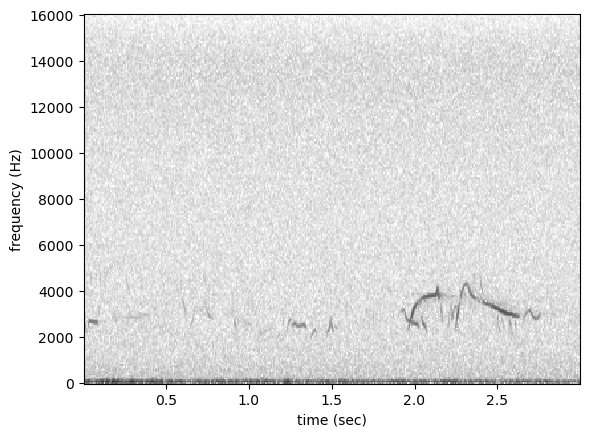

In [30]:
show_sample_from_df(train_df, 'present')

# Shuffle the training data

In [31]:
train_df = train_df.sample(frac=1)
balanced_valid_df = balanced_valid_df.sample(frac=1)

# Drop the redundant absence class

In [32]:
train_df = train_df[["target_presence"]]
balanced_valid_df = balanced_valid_df[["target_presence"]]
train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

# Calculate recording durations for each recording in the training data
Some recordings might be corrupt and have zero samples. 

In [33]:
## Only need to do this if training fails due to zero length samples

# train_recording_durations = get_recording_durations(balanced_train_df)
# balanced_train_df['recording_duration'] = train_recording_durations
# balanced_train_df.loc[balanced_train_df['recording_duration'] < 3]

In [34]:
len(train_df)

7685

# Create a CNN

In [35]:
import timm
arch = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("best_of")
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("repetition_penalty")
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-pa

In [36]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = arch

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
    
)
# Set this to 'True' if there are more than one possible target class (present, absent, other) and only one label can be true. Set it to 'False' if there is only one output node - this will allow a threshold to be set on the output score and will allow use of sigmoid instead of softmax on the output layer. 
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

# Specify min and max frequencies for bandpass

In [37]:
if bandpass:
    model.preprocessor.pipeline.bandpass.params.min_f = min_freq
    model.preprocessor.pipeline.bandpass.params.max_f = max_freq
    model.preprocessor.pipeline.bandpass.params

# Inspect the input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

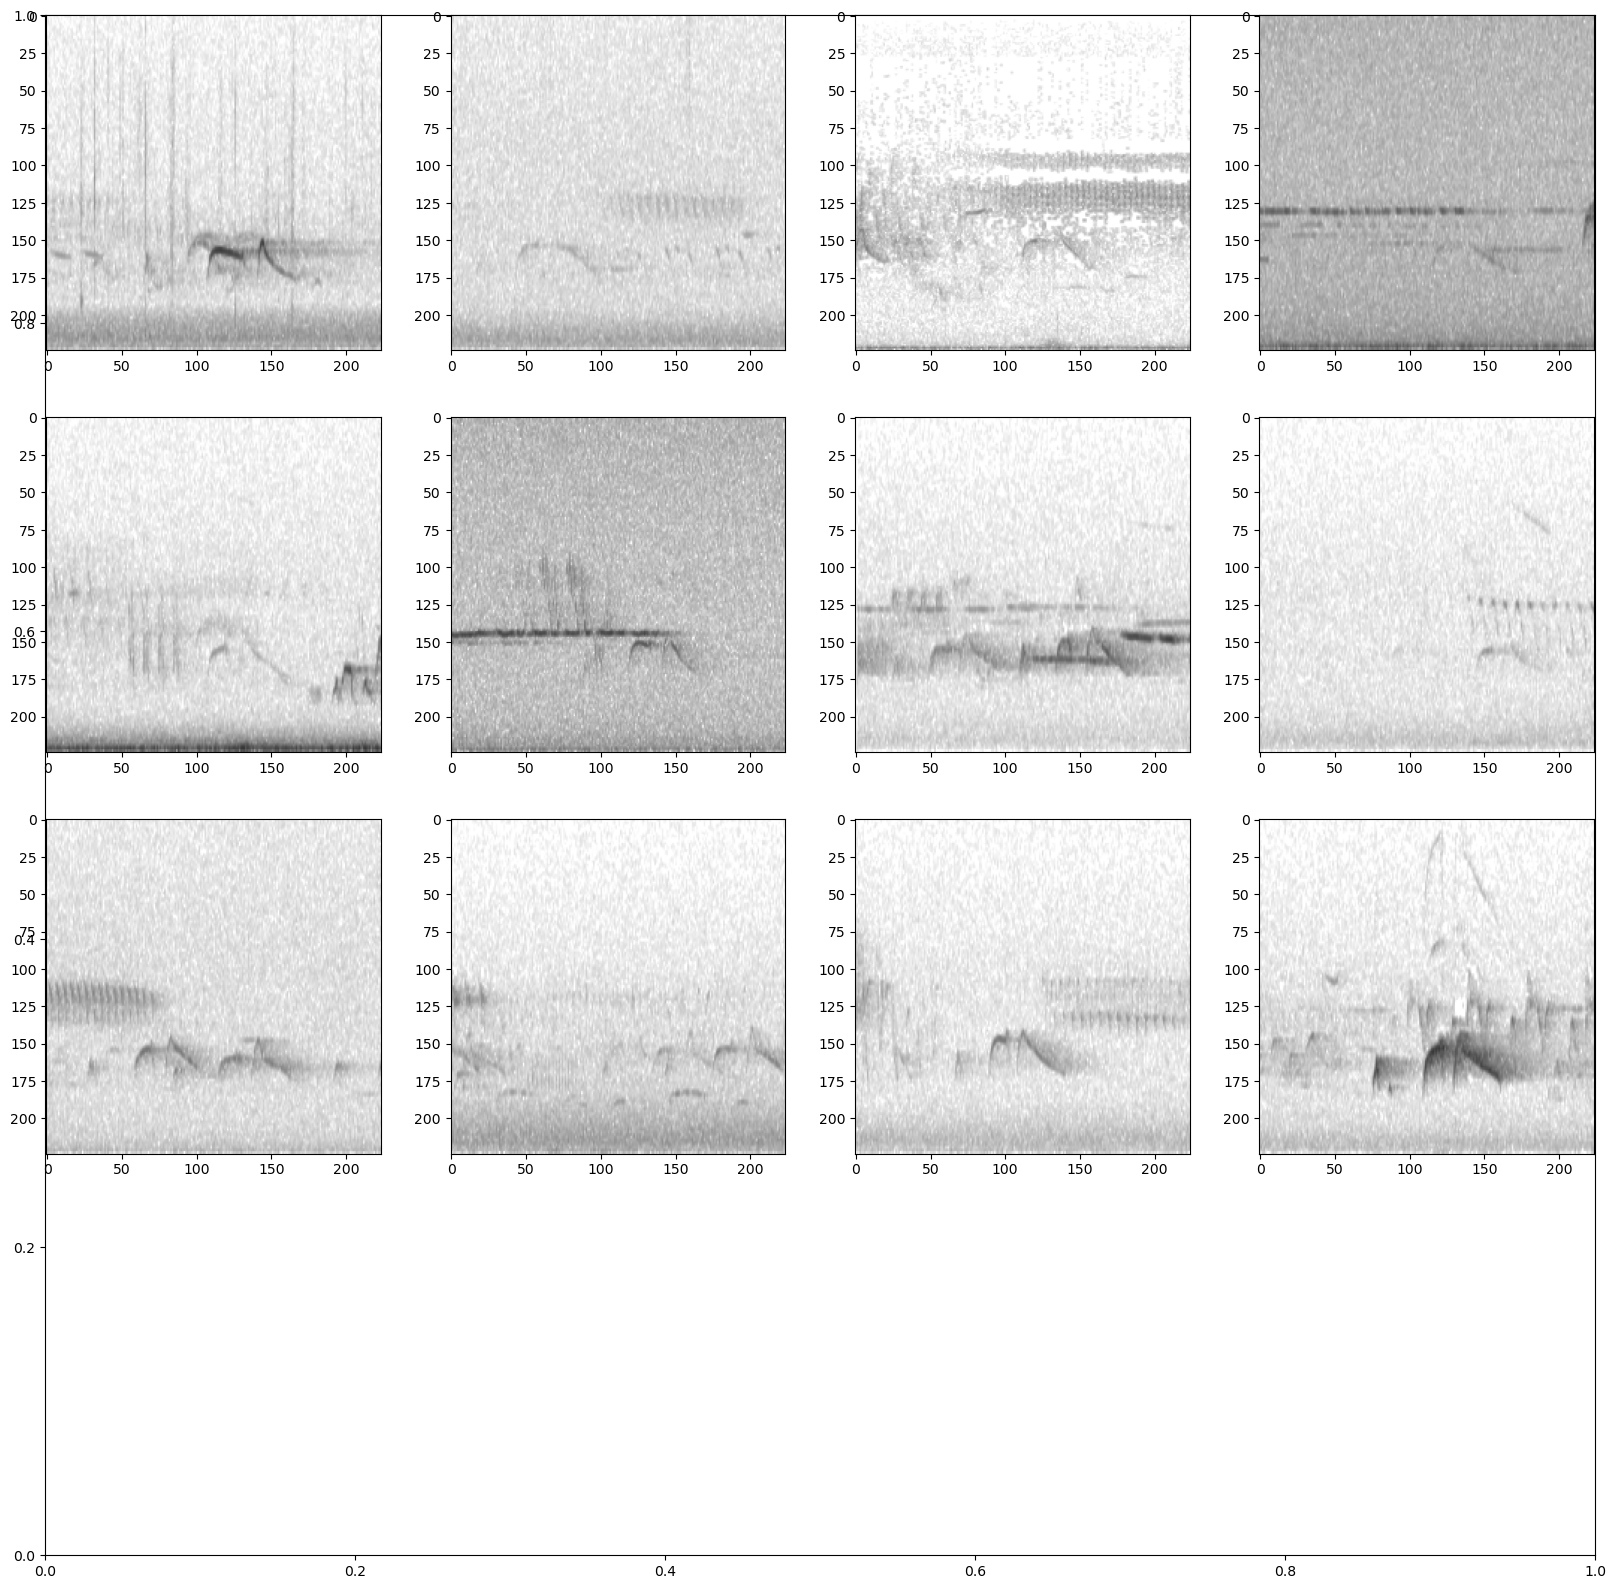

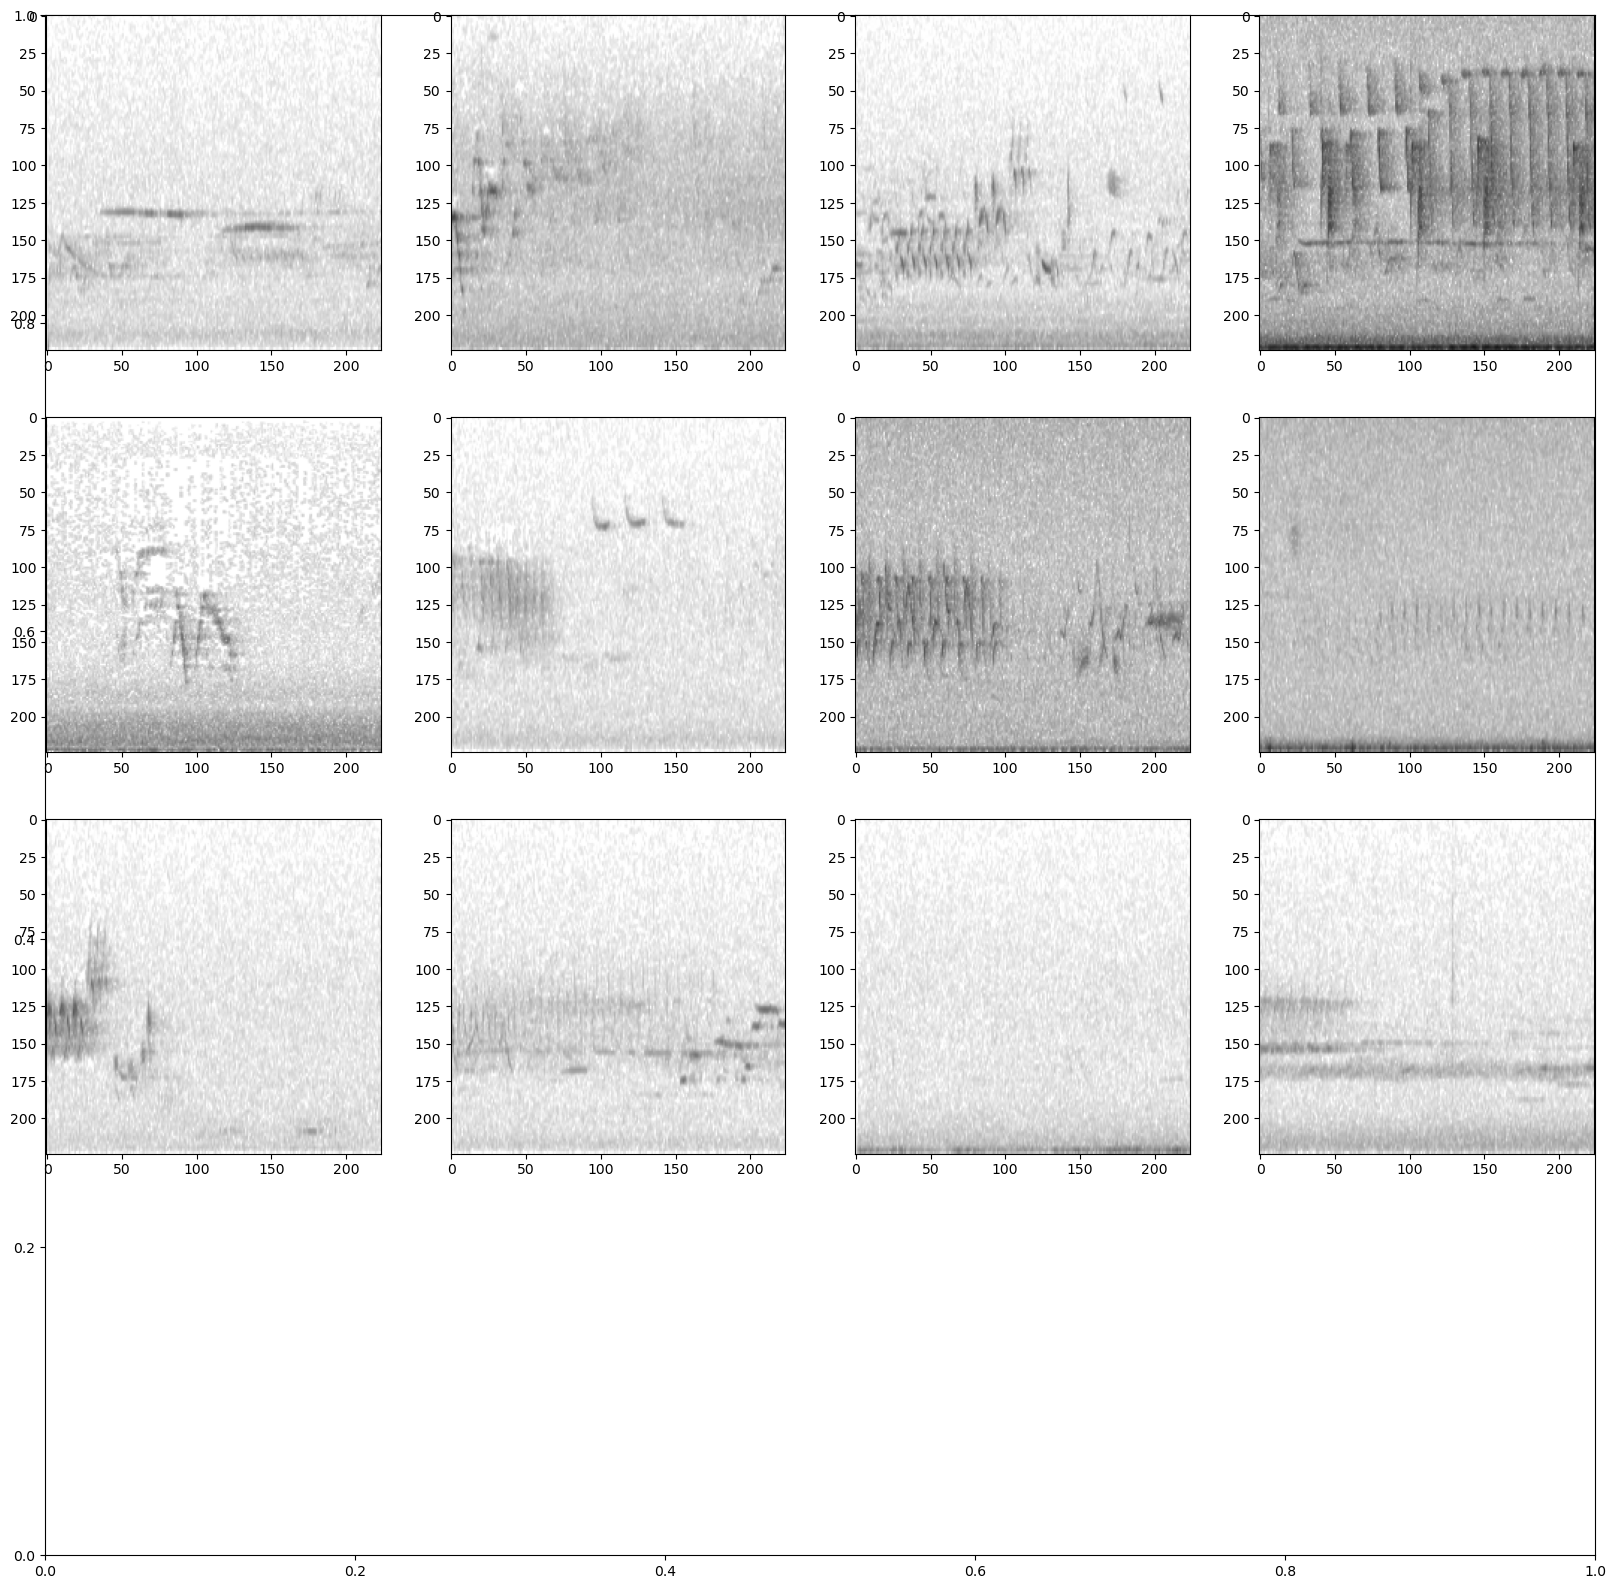

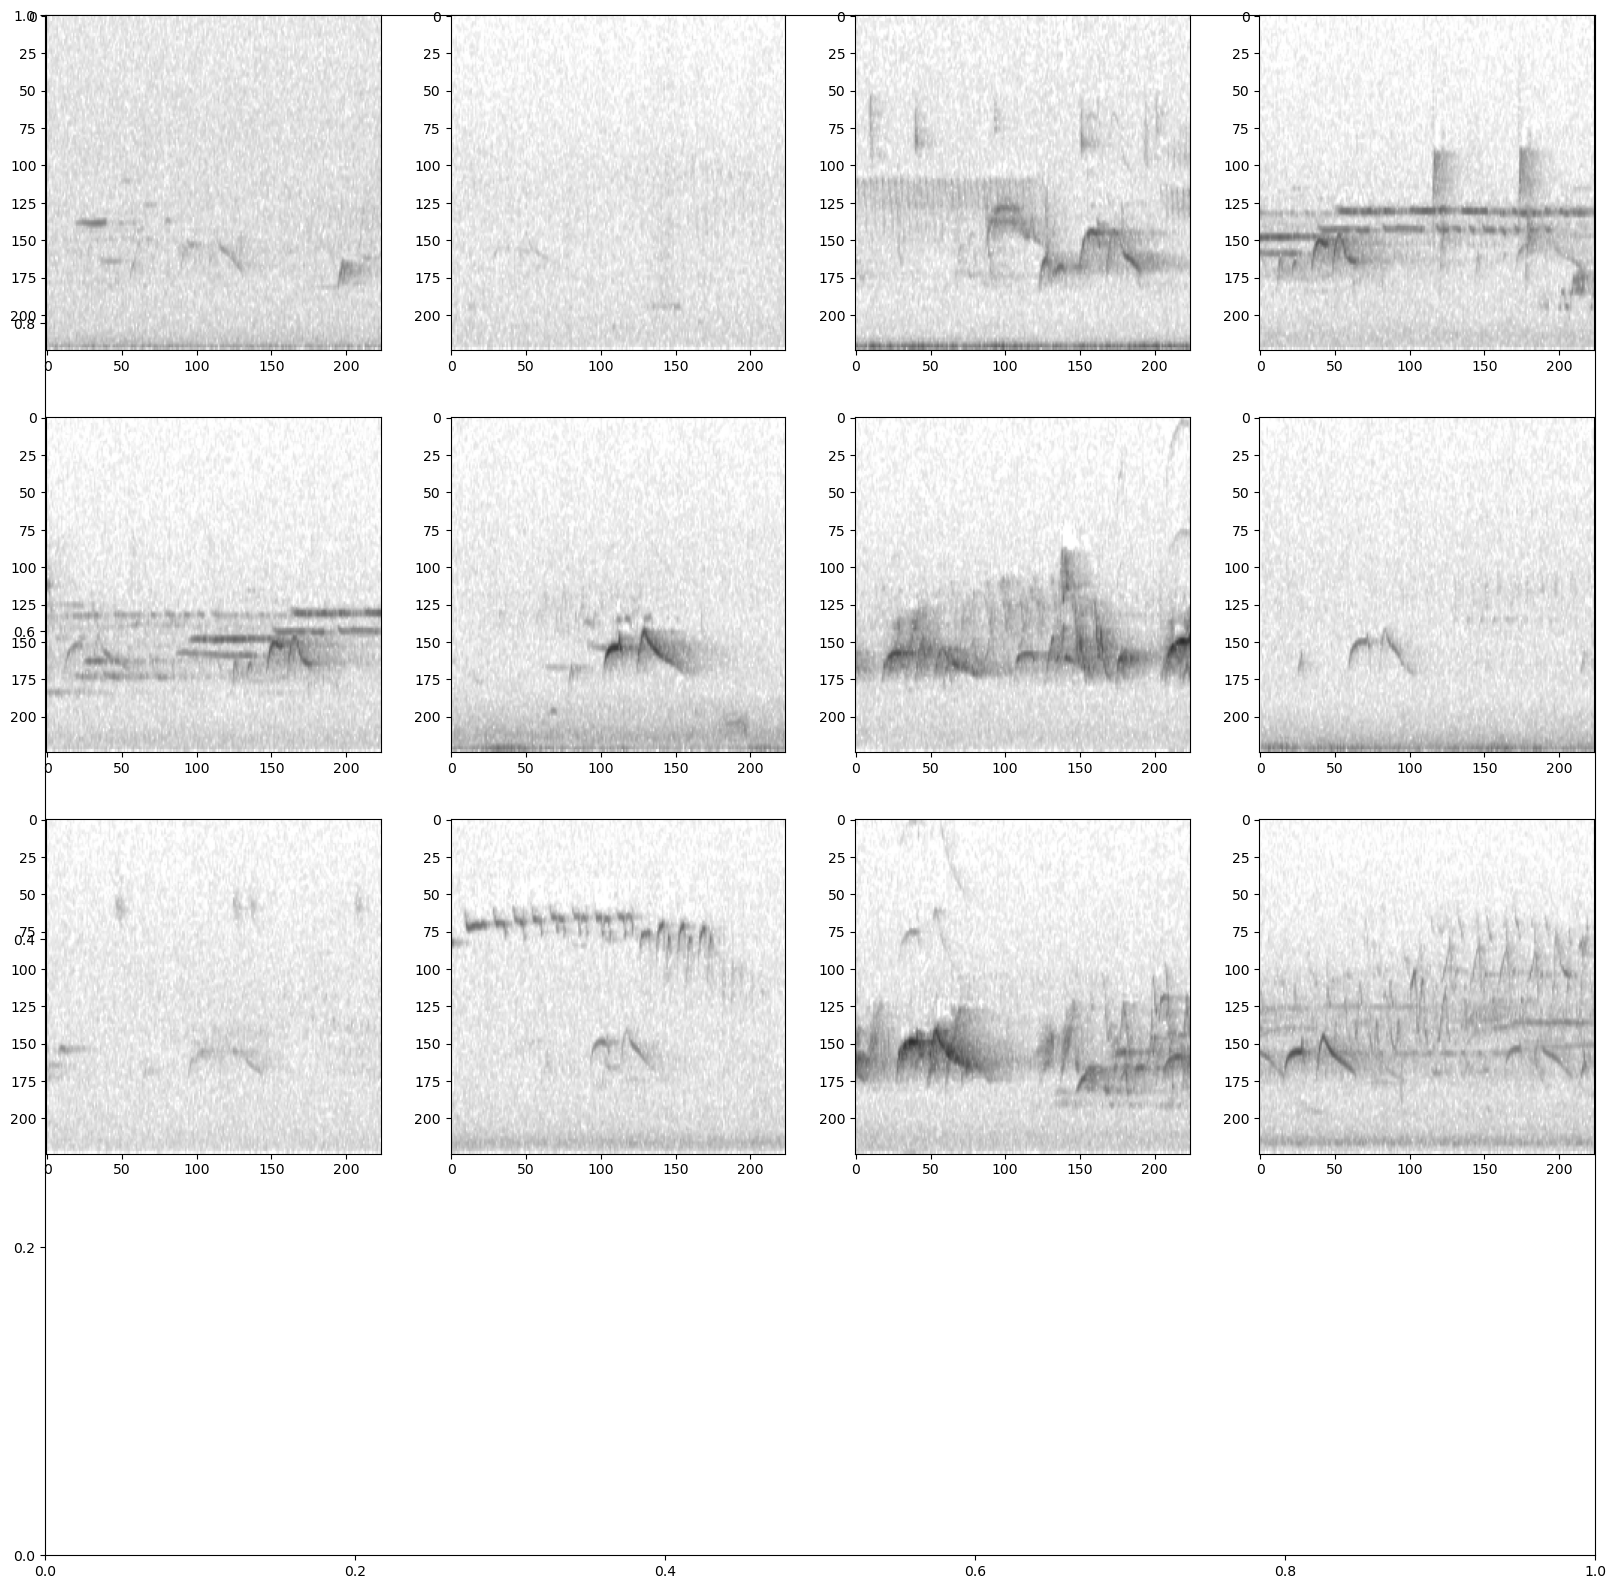

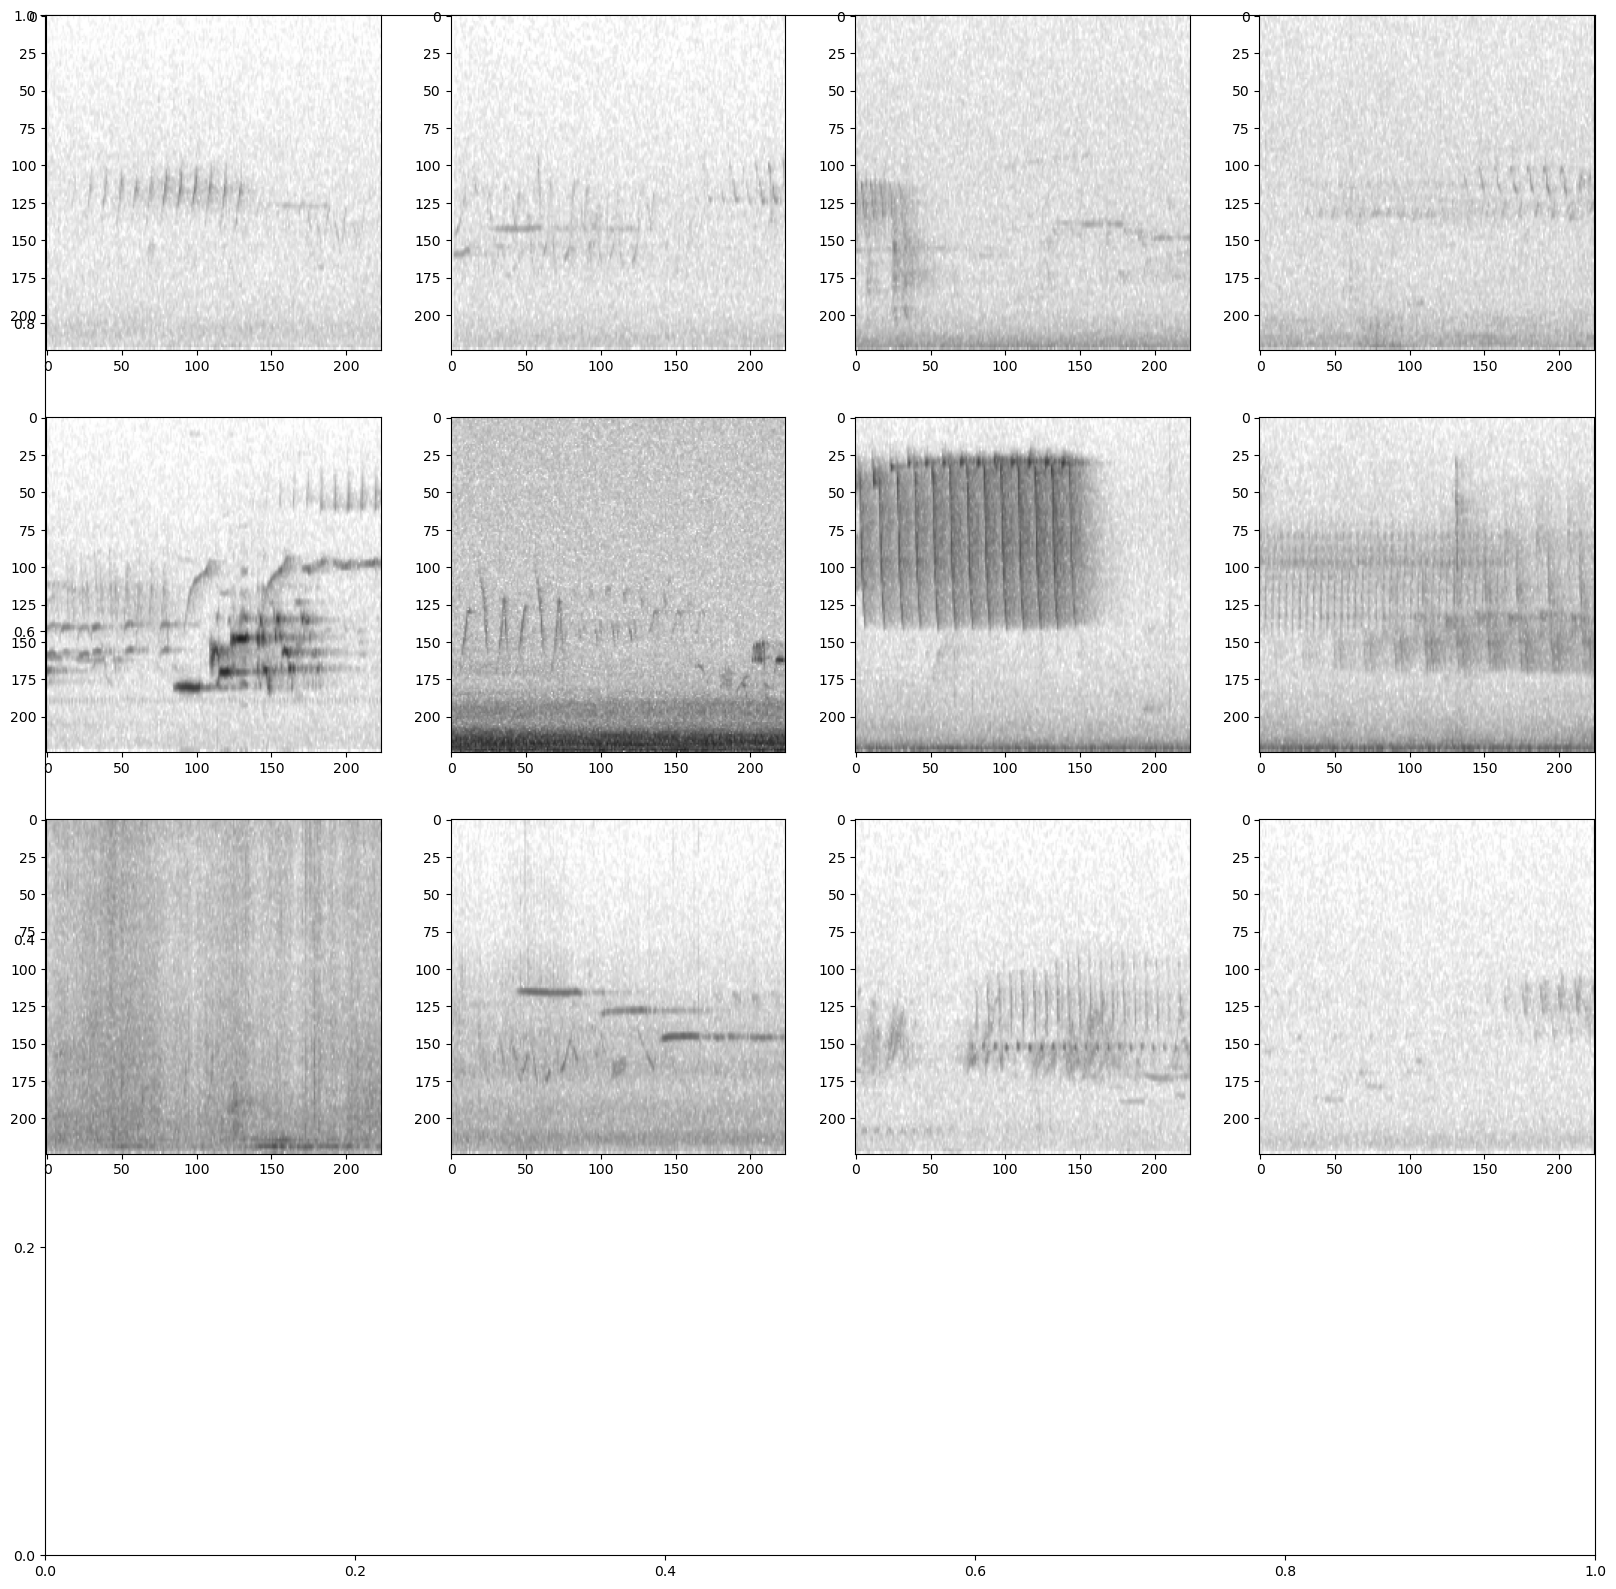

In [38]:
def inspect_input_samples(train_df, valid_df):
    present_t = train_df.loc[train_df.target_presence == 1]
    absent_t = train_df.loc[train_df.target_presence == 0]
    present_v = valid_df.loc[valid_df.target_presence == 1]
    absent_v = valid_df.loc[valid_df.target_presence == 0]

    # Generate a dataset with the samples we wish to inspect and the model's preprocessor
    for df in [present_t, absent_t, present_v, absent_v]:
        inspection_dataset = opso.AudioFileDataset(df.sample(12), model.preprocessor)
        inspection_dataset.bypass_augmentations = True

        samples = [sample.data for sample in inspection_dataset]
        _ = show_tensor_grid(samples, 4, invert=True)

inspect_input_samples(train_df, balanced_valid_df)


# Check for leakage

In [39]:
train_files = train_df.index.get_level_values("file")
valid_files = balanced_valid_df.index.get_level_values("file")
assert train_files.isin(valid_files).sum() == 0, "Train and validation sets have overlapping files"

In [40]:
model.optimizer_params['lr'] = learning_rate

In [41]:
model.network

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [42]:
class_list

['target_presence']

In [43]:
def show_sample_from_df(df=train_df, present=True,):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


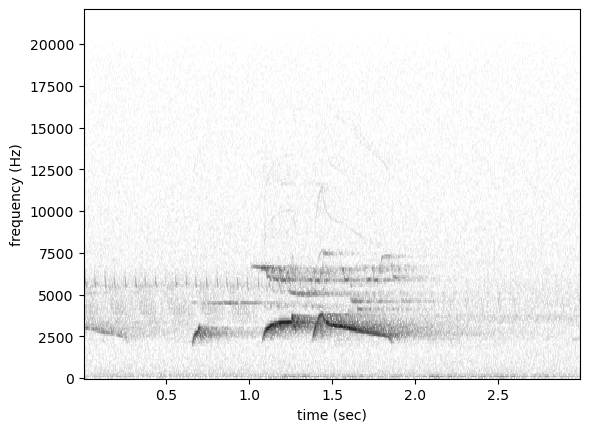

In [44]:
show_sample_from_df(df=train_df, present=True)


In [45]:
print(f'model.device is: {model.device}')

model.device is: mps


In [46]:
Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb"

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb')

In [47]:
%set_env WANDB_NOTEBOOK_NAME={Path(Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb")}

env: WANDB_NOTEBOOK_NAME=/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb


# Weights and biases initialization

In [48]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [49]:
balanced_valid_df.value_counts()


target_presence
0.0                380
1.0                380
Name: count, dtype: int64

In [50]:
train_df.value_counts()

target_presence
0.0                3942
1.0                3743
Name: count, dtype: int64

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
model.train(
    train_df,
    balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 2, #4 parallelized cpu tasks for preprocessing, Reduce if training quits unexpectedly
    log_interval = 10,
    save_interval = 1,
    invalid_samples_log='./invalid_training_samples.log',
    raise_errors=True,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 0 [batch 0/121, 0.00%] 
	DistLoss: 2.514
Metrics:
Epoch: 0 [batch 10/121, 8.26%] 
	DistLoss: 2.037
Metrics:
Epoch: 0 [batch 20/121, 16.53%] 
	DistLoss: 2.135
Metrics:
Epoch: 0 [batch 30/121, 24.79%] 
	DistLoss: 1.963
Metrics:
Epoch: 0 [batch 40/121, 33.06%] 
	DistLoss: 1.762
Metrics:
Epoch: 0 [batch 50/121, 41.32%] 
	DistLoss: 1.531
Metrics:
Epoch: 0 [batch 60/121, 49.59%] 
	DistLoss: 1.369
Metrics:
Epoch: 0 [batch 70/121, 57.85%] 
	DistLoss: 1.235
Metrics:
Epoch: 0 [batch 80/121, 66.12%] 
	DistLoss: 1.132
Metrics:
Epoch: 0 [batch 90/121, 74.38%] 
	DistLoss: 1.059
Metrics:
Epoch: 0 [batch 100/121, 82.64%] 
	DistLoss: 0.999
Metrics:
Epoch: 0 [batch 110/121, 90.91%] 
	DistLoss: 0.942
Metrics:
Epoch: 0 [batch 120/121, 99.17%] 
	DistLoss: 0.899
Metrics:
Metrics:
	MAP: 0.840

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.977

Training Epoch 1


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 1 [batch 0/121, 0.00%] 
	DistLoss: 0.445
Metrics:
Epoch: 1 [batch 10/121, 8.26%] 
	DistLoss: 0.347
Metrics:
Epoch: 1 [batch 20/121, 16.53%] 
	DistLoss: 0.342
Metrics:
Epoch: 1 [batch 30/121, 24.79%] 
	DistLoss: 0.330
Metrics:
Epoch: 1 [batch 40/121, 33.06%] 
	DistLoss: 0.321
Metrics:
Epoch: 1 [batch 50/121, 41.32%] 
	DistLoss: 0.327
Metrics:
Epoch: 1 [batch 60/121, 49.59%] 
	DistLoss: 0.326
Metrics:
Epoch: 1 [batch 70/121, 57.85%] 
	DistLoss: 0.332
Metrics:
Epoch: 1 [batch 80/121, 66.12%] 
	DistLoss: 0.327
Metrics:
Epoch: 1 [batch 90/121, 74.38%] 
	DistLoss: 0.320
Metrics:
Epoch: 1 [batch 100/121, 82.64%] 
	DistLoss: 0.319
Metrics:
Epoch: 1 [batch 110/121, 90.91%] 
	DistLoss: 0.317
Metrics:
Epoch: 1 [batch 120/121, 99.17%] 
	DistLoss: 0.312
Metrics:
Metrics:
	MAP: 0.944

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.986

Training Epoch 2


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 2 [batch 0/121, 0.00%] 
	DistLoss: 0.333
Metrics:
Epoch: 2 [batch 10/121, 8.26%] 
	DistLoss: 0.279
Metrics:
Epoch: 2 [batch 20/121, 16.53%] 
	DistLoss: 0.267
Metrics:
Epoch: 2 [batch 30/121, 24.79%] 
	DistLoss: 0.259
Metrics:
Epoch: 2 [batch 40/121, 33.06%] 
	DistLoss: 0.279
Metrics:
Epoch: 2 [batch 50/121, 41.32%] 
	DistLoss: 0.283
Metrics:
Epoch: 2 [batch 60/121, 49.59%] 
	DistLoss: 0.282
Metrics:
Epoch: 2 [batch 70/121, 57.85%] 
	DistLoss: 0.284
Metrics:
Epoch: 2 [batch 80/121, 66.12%] 
	DistLoss: 0.287
Metrics:
Epoch: 2 [batch 90/121, 74.38%] 
	DistLoss: 0.286
Metrics:
Epoch: 2 [batch 100/121, 82.64%] 
	DistLoss: 0.286
Metrics:
Epoch: 2 [batch 110/121, 90.91%] 
	DistLoss: 0.283
Metrics:
Epoch: 2 [batch 120/121, 99.17%] 
	DistLoss: 0.281
Metrics:
Metrics:
	MAP: 0.954

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.992

Training Epoch 3


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 3 [batch 0/121, 0.00%] 
	DistLoss: 0.212
Metrics:
Epoch: 3 [batch 10/121, 8.26%] 
	DistLoss: 0.290
Metrics:
Epoch: 3 [batch 20/121, 16.53%] 
	DistLoss: 0.320
Metrics:
Epoch: 3 [batch 30/121, 24.79%] 
	DistLoss: 0.306
Metrics:
Epoch: 3 [batch 40/121, 33.06%] 
	DistLoss: 0.301
Metrics:
Epoch: 3 [batch 50/121, 41.32%] 
	DistLoss: 0.294
Metrics:
Epoch: 3 [batch 60/121, 49.59%] 
	DistLoss: 0.287
Metrics:
Epoch: 3 [batch 70/121, 57.85%] 
	DistLoss: 0.283
Metrics:
Epoch: 3 [batch 80/121, 66.12%] 
	DistLoss: 0.280
Metrics:
Epoch: 3 [batch 90/121, 74.38%] 
	DistLoss: 0.281
Metrics:
Epoch: 3 [batch 100/121, 82.64%] 
	DistLoss: 0.279
Metrics:
Epoch: 3 [batch 110/121, 90.91%] 
	DistLoss: 0.277
Metrics:
Epoch: 3 [batch 120/121, 99.17%] 
	DistLoss: 0.281
Metrics:
Metrics:
	MAP: 0.957

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.989

Training Epoch 4


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 4 [batch 0/121, 0.00%] 
	DistLoss: 0.341
Metrics:
Epoch: 4 [batch 10/121, 8.26%] 
	DistLoss: 0.384
Metrics:
Epoch: 4 [batch 20/121, 16.53%] 
	DistLoss: 0.342
Metrics:
Epoch: 4 [batch 30/121, 24.79%] 
	DistLoss: 0.317
Metrics:
Epoch: 4 [batch 40/121, 33.06%] 
	DistLoss: 0.315
Metrics:
Epoch: 4 [batch 50/121, 41.32%] 
	DistLoss: 0.309
Metrics:
Epoch: 4 [batch 60/121, 49.59%] 
	DistLoss: 0.300
Metrics:
Epoch: 4 [batch 70/121, 57.85%] 
	DistLoss: 0.300
Metrics:
Epoch: 4 [batch 80/121, 66.12%] 
	DistLoss: 0.294
Metrics:
Epoch: 4 [batch 90/121, 74.38%] 
	DistLoss: 0.288
Metrics:
Epoch: 4 [batch 100/121, 82.64%] 
	DistLoss: 0.284
Metrics:
Epoch: 4 [batch 110/121, 90.91%] 
	DistLoss: 0.282
Metrics:
Epoch: 4 [batch 120/121, 99.17%] 
	DistLoss: 0.279
Metrics:
Metrics:
	MAP: 0.956

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.987

Training Epoch 5


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 5 [batch 0/121, 0.00%] 
	DistLoss: 0.157
Metrics:
Epoch: 5 [batch 10/121, 8.26%] 
	DistLoss: 0.243
Metrics:
Epoch: 5 [batch 20/121, 16.53%] 
	DistLoss: 0.234
Metrics:
Epoch: 5 [batch 30/121, 24.79%] 
	DistLoss: 0.232
Metrics:
Epoch: 5 [batch 40/121, 33.06%] 
	DistLoss: 0.239
Metrics:
Epoch: 5 [batch 50/121, 41.32%] 
	DistLoss: 0.234
Metrics:
Epoch: 5 [batch 60/121, 49.59%] 
	DistLoss: 0.228
Metrics:
Epoch: 5 [batch 70/121, 57.85%] 
	DistLoss: 0.237
Metrics:
Epoch: 5 [batch 80/121, 66.12%] 
	DistLoss: 0.241
Metrics:
Epoch: 5 [batch 90/121, 74.38%] 
	DistLoss: 0.241
Metrics:
Epoch: 5 [batch 100/121, 82.64%] 
	DistLoss: 0.243
Metrics:
Epoch: 5 [batch 110/121, 90.91%] 
	DistLoss: 0.239
Metrics:
Epoch: 5 [batch 120/121, 99.17%] 
	DistLoss: 0.238
Metrics:
Metrics:
	MAP: 0.967

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.991

Training Epoch 6


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 6 [batch 0/121, 0.00%] 
	DistLoss: 0.285
Metrics:
Epoch: 6 [batch 10/121, 8.26%] 
	DistLoss: 0.225
Metrics:
Epoch: 6 [batch 20/121, 16.53%] 
	DistLoss: 0.217
Metrics:
Epoch: 6 [batch 30/121, 24.79%] 
	DistLoss: 0.217
Metrics:
Epoch: 6 [batch 40/121, 33.06%] 
	DistLoss: 0.223
Metrics:
Epoch: 6 [batch 50/121, 41.32%] 
	DistLoss: 0.217
Metrics:
Epoch: 6 [batch 60/121, 49.59%] 
	DistLoss: 0.221
Metrics:
Epoch: 6 [batch 70/121, 57.85%] 
	DistLoss: 0.225
Metrics:
Epoch: 6 [batch 80/121, 66.12%] 
	DistLoss: 0.222
Metrics:
Epoch: 6 [batch 90/121, 74.38%] 
	DistLoss: 0.224
Metrics:
Epoch: 6 [batch 100/121, 82.64%] 
	DistLoss: 0.222
Metrics:
Epoch: 6 [batch 110/121, 90.91%] 
	DistLoss: 0.218
Metrics:
Epoch: 6 [batch 120/121, 99.17%] 
	DistLoss: 0.219
Metrics:
Metrics:
	MAP: 0.973

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.994

Training Epoch 7


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 7 [batch 0/121, 0.00%] 
	DistLoss: 0.278
Metrics:
Epoch: 7 [batch 10/121, 8.26%] 
	DistLoss: 0.226
Metrics:
Epoch: 7 [batch 20/121, 16.53%] 
	DistLoss: 0.216
Metrics:
Epoch: 7 [batch 30/121, 24.79%] 
	DistLoss: 0.213
Metrics:
Epoch: 7 [batch 40/121, 33.06%] 
	DistLoss: 0.224
Metrics:
Epoch: 7 [batch 50/121, 41.32%] 
	DistLoss: 0.219
Metrics:
Epoch: 7 [batch 60/121, 49.59%] 
	DistLoss: 0.219
Metrics:
Epoch: 7 [batch 70/121, 57.85%] 
	DistLoss: 0.219
Metrics:
Epoch: 7 [batch 80/121, 66.12%] 
	DistLoss: 0.217
Metrics:
Epoch: 7 [batch 90/121, 74.38%] 
	DistLoss: 0.216
Metrics:
Epoch: 7 [batch 100/121, 82.64%] 
	DistLoss: 0.215
Metrics:
Epoch: 7 [batch 110/121, 90.91%] 
	DistLoss: 0.215
Metrics:
Epoch: 7 [batch 120/121, 99.17%] 
	DistLoss: 0.214
Metrics:
Metrics:
	MAP: 0.973

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.996

Training Epoch 8


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 8 [batch 0/121, 0.00%] 
	DistLoss: 0.131
Metrics:
Epoch: 8 [batch 10/121, 8.26%] 
	DistLoss: 0.219
Metrics:
Epoch: 8 [batch 20/121, 16.53%] 
	DistLoss: 0.210
Metrics:
Epoch: 8 [batch 30/121, 24.79%] 
	DistLoss: 0.199
Metrics:
Epoch: 8 [batch 40/121, 33.06%] 
	DistLoss: 0.194
Metrics:
Epoch: 8 [batch 50/121, 41.32%] 
	DistLoss: 0.196
Metrics:
Epoch: 8 [batch 60/121, 49.59%] 
	DistLoss: 0.197
Metrics:
Epoch: 8 [batch 70/121, 57.85%] 
	DistLoss: 0.196
Metrics:
Epoch: 8 [batch 80/121, 66.12%] 
	DistLoss: 0.195
Metrics:
Epoch: 8 [batch 90/121, 74.38%] 
	DistLoss: 0.194
Metrics:
Epoch: 8 [batch 100/121, 82.64%] 
	DistLoss: 0.196
Metrics:
Epoch: 8 [batch 110/121, 90.91%] 
	DistLoss: 0.195
Metrics:
Epoch: 8 [batch 120/121, 99.17%] 
	DistLoss: 0.195
Metrics:
Metrics:
	MAP: 0.978

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.997

Training Epoch 9


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 9 [batch 0/121, 0.00%] 
	DistLoss: 0.112
Metrics:
Epoch: 9 [batch 10/121, 8.26%] 
	DistLoss: 0.179
Metrics:
Epoch: 9 [batch 20/121, 16.53%] 
	DistLoss: 0.199
Metrics:
Epoch: 9 [batch 30/121, 24.79%] 
	DistLoss: 0.198
Metrics:
Epoch: 9 [batch 40/121, 33.06%] 
	DistLoss: 0.193
Metrics:
Epoch: 9 [batch 50/121, 41.32%] 
	DistLoss: 0.199
Metrics:
Epoch: 9 [batch 60/121, 49.59%] 
	DistLoss: 0.201
Metrics:
Epoch: 9 [batch 70/121, 57.85%] 
	DistLoss: 0.200
Metrics:
Epoch: 9 [batch 80/121, 66.12%] 
	DistLoss: 0.198
Metrics:
Epoch: 9 [batch 90/121, 74.38%] 
	DistLoss: 0.193
Metrics:
Epoch: 9 [batch 100/121, 82.64%] 
	DistLoss: 0.191
Metrics:
Epoch: 9 [batch 110/121, 90.91%] 
	DistLoss: 0.190
Metrics:
Epoch: 9 [batch 120/121, 99.17%] 
	DistLoss: 0.186
Metrics:
Metrics:
	MAP: 0.979

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.996

Training Epoch 10


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 10 [batch 0/121, 0.00%] 
	DistLoss: 0.179
Metrics:
Epoch: 10 [batch 10/121, 8.26%] 
	DistLoss: 0.167
Metrics:
Epoch: 10 [batch 20/121, 16.53%] 
	DistLoss: 0.180
Metrics:
Epoch: 10 [batch 30/121, 24.79%] 
	DistLoss: 0.186
Metrics:
Epoch: 10 [batch 40/121, 33.06%] 
	DistLoss: 0.185
Metrics:
Epoch: 10 [batch 50/121, 41.32%] 
	DistLoss: 0.194
Metrics:
Epoch: 10 [batch 60/121, 49.59%] 
	DistLoss: 0.192
Metrics:
Epoch: 10 [batch 70/121, 57.85%] 
	DistLoss: 0.192
Metrics:
Epoch: 10 [batch 80/121, 66.12%] 
	DistLoss: 0.191
Metrics:
Epoch: 10 [batch 90/121, 74.38%] 
	DistLoss: 0.185
Metrics:
Epoch: 10 [batch 100/121, 82.64%] 
	DistLoss: 0.187
Metrics:
Epoch: 10 [batch 110/121, 90.91%] 
	DistLoss: 0.192
Metrics:
Epoch: 10 [batch 120/121, 99.17%] 
	DistLoss: 0.189
Metrics:
Metrics:
	MAP: 0.979

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.996

Training Epoch 11


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 11 [batch 0/121, 0.00%] 
	DistLoss: 0.245
Metrics:
Epoch: 11 [batch 10/121, 8.26%] 
	DistLoss: 0.168
Metrics:
Epoch: 11 [batch 20/121, 16.53%] 
	DistLoss: 0.169
Metrics:
Epoch: 11 [batch 30/121, 24.79%] 
	DistLoss: 0.173
Metrics:
Epoch: 11 [batch 40/121, 33.06%] 
	DistLoss: 0.171
Metrics:
Epoch: 11 [batch 50/121, 41.32%] 
	DistLoss: 0.176
Metrics:
Epoch: 11 [batch 60/121, 49.59%] 
	DistLoss: 0.174
Metrics:
Epoch: 11 [batch 70/121, 57.85%] 
	DistLoss: 0.175
Metrics:
Epoch: 11 [batch 80/121, 66.12%] 
	DistLoss: 0.175
Metrics:
Epoch: 11 [batch 90/121, 74.38%] 
	DistLoss: 0.176
Metrics:
Epoch: 11 [batch 100/121, 82.64%] 
	DistLoss: 0.175
Metrics:
Epoch: 11 [batch 110/121, 90.91%] 
	DistLoss: 0.176
Metrics:
Epoch: 11 [batch 120/121, 99.17%] 
	DistLoss: 0.173
Metrics:
Metrics:
	MAP: 0.982

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.996

Training Epoch 12


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 12 [batch 0/121, 0.00%] 
	DistLoss: 0.243
Metrics:
Epoch: 12 [batch 10/121, 8.26%] 
	DistLoss: 0.141
Metrics:
Epoch: 12 [batch 20/121, 16.53%] 
	DistLoss: 0.165
Metrics:
Epoch: 12 [batch 30/121, 24.79%] 
	DistLoss: 0.161
Metrics:
Epoch: 12 [batch 40/121, 33.06%] 
	DistLoss: 0.164
Metrics:
Epoch: 12 [batch 50/121, 41.32%] 
	DistLoss: 0.172
Metrics:
Epoch: 12 [batch 60/121, 49.59%] 
	DistLoss: 0.175
Metrics:
Epoch: 12 [batch 70/121, 57.85%] 
	DistLoss: 0.177
Metrics:
Epoch: 12 [batch 80/121, 66.12%] 
	DistLoss: 0.174
Metrics:
Epoch: 12 [batch 90/121, 74.38%] 
	DistLoss: 0.173
Metrics:
Epoch: 12 [batch 100/121, 82.64%] 
	DistLoss: 0.174
Metrics:
Epoch: 12 [batch 110/121, 90.91%] 
	DistLoss: 0.173
Metrics:
Epoch: 12 [batch 120/121, 99.17%] 
	DistLoss: 0.176
Metrics:
Metrics:
	MAP: 0.982

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.997

Training Epoch 13


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 13 [batch 0/121, 0.00%] 
	DistLoss: 0.178
Metrics:
Epoch: 13 [batch 10/121, 8.26%] 
	DistLoss: 0.191
Metrics:
Epoch: 13 [batch 20/121, 16.53%] 
	DistLoss: 0.186
Metrics:
Epoch: 13 [batch 30/121, 24.79%] 
	DistLoss: 0.179
Metrics:
Epoch: 13 [batch 40/121, 33.06%] 
	DistLoss: 0.169
Metrics:
Epoch: 13 [batch 50/121, 41.32%] 
	DistLoss: 0.171
Metrics:
Epoch: 13 [batch 60/121, 49.59%] 
	DistLoss: 0.173
Metrics:
Epoch: 13 [batch 70/121, 57.85%] 
	DistLoss: 0.176
Metrics:
Epoch: 13 [batch 80/121, 66.12%] 
	DistLoss: 0.175
Metrics:
Epoch: 13 [batch 90/121, 74.38%] 
	DistLoss: 0.175
Metrics:
Epoch: 13 [batch 100/121, 82.64%] 
	DistLoss: 0.172
Metrics:
Epoch: 13 [batch 110/121, 90.91%] 
	DistLoss: 0.171
Metrics:
Epoch: 13 [batch 120/121, 99.17%] 
	DistLoss: 0.168
Metrics:
Metrics:
	MAP: 0.983

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.995

Training Epoch 14


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 14 [batch 0/121, 0.00%] 
	DistLoss: 0.225
Metrics:
Epoch: 14 [batch 10/121, 8.26%] 
	DistLoss: 0.169
Metrics:
Epoch: 14 [batch 20/121, 16.53%] 
	DistLoss: 0.164
Metrics:
Epoch: 14 [batch 30/121, 24.79%] 
	DistLoss: 0.160
Metrics:
Epoch: 14 [batch 40/121, 33.06%] 
	DistLoss: 0.163
Metrics:
Epoch: 14 [batch 50/121, 41.32%] 
	DistLoss: 0.160
Metrics:
Epoch: 14 [batch 60/121, 49.59%] 
	DistLoss: 0.159
Metrics:
Epoch: 14 [batch 70/121, 57.85%] 
	DistLoss: 0.154
Metrics:
Epoch: 14 [batch 80/121, 66.12%] 
	DistLoss: 0.158
Metrics:
Epoch: 14 [batch 90/121, 74.38%] 
	DistLoss: 0.159
Metrics:
Epoch: 14 [batch 100/121, 82.64%] 
	DistLoss: 0.161
Metrics:
Epoch: 14 [batch 110/121, 90.91%] 
	DistLoss: 0.160
Metrics:
Epoch: 14 [batch 120/121, 99.17%] 
	DistLoss: 0.202
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
	MAP: 0.984

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.994

Training Epoch 15


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 15 [batch 0/121, 0.00%] 
	DistLoss: 0.316
Metrics:
Epoch: 15 [batch 10/121, 8.26%] 
	DistLoss: 0.306
Metrics:
Epoch: 15 [batch 20/121, 16.53%] 
	DistLoss: 0.265
Metrics:
Epoch: 15 [batch 30/121, 24.79%] 
	DistLoss: 0.249
Metrics:
Epoch: 15 [batch 40/121, 33.06%] 
	DistLoss: 0.231
Metrics:
Epoch: 15 [batch 50/121, 41.32%] 
	DistLoss: 0.215
Metrics:
Epoch: 15 [batch 60/121, 49.59%] 
	DistLoss: 0.207
Metrics:
Epoch: 15 [batch 70/121, 57.85%] 
	DistLoss: 0.199
Metrics:
Epoch: 15 [batch 80/121, 66.12%] 
	DistLoss: 0.200
Metrics:
Epoch: 15 [batch 90/121, 74.38%] 
	DistLoss: 0.197
Metrics:
Epoch: 15 [batch 100/121, 82.64%] 
	DistLoss: 0.193
Metrics:
Epoch: 15 [batch 110/121, 90.91%] 
	DistLoss: 0.195
Metrics:
Epoch: 15 [batch 120/121, 99.17%] 
	DistLoss: 0.189
Metrics:
Metrics:
	MAP: 0.979

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.997

Training Epoch 16


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 16 [batch 0/121, 0.00%] 
	DistLoss: 0.084
Metrics:
Epoch: 16 [batch 10/121, 8.26%] 
	DistLoss: 0.171
Metrics:
Epoch: 16 [batch 20/121, 16.53%] 
	DistLoss: 0.165
Metrics:
Epoch: 16 [batch 30/121, 24.79%] 
	DistLoss: 0.171
Metrics:
Epoch: 16 [batch 40/121, 33.06%] 
	DistLoss: 0.174
Metrics:
Epoch: 16 [batch 50/121, 41.32%] 
	DistLoss: 0.174
Metrics:
Epoch: 16 [batch 60/121, 49.59%] 
	DistLoss: 0.172
Metrics:
Epoch: 16 [batch 70/121, 57.85%] 
	DistLoss: 0.171
Metrics:
Epoch: 16 [batch 80/121, 66.12%] 
	DistLoss: 0.176
Metrics:
Epoch: 16 [batch 90/121, 74.38%] 
	DistLoss: 0.172
Metrics:
Epoch: 16 [batch 100/121, 82.64%] 
	DistLoss: 0.171
Metrics:
Epoch: 16 [batch 110/121, 90.91%] 
	DistLoss: 0.169
Metrics:
Epoch: 16 [batch 120/121, 99.17%] 
	DistLoss: 0.177
Metrics:
Metrics:
	MAP: 0.983

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.997

Training Epoch 17


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 17 [batch 0/121, 0.00%] 
	DistLoss: 0.232
Metrics:
Epoch: 17 [batch 10/121, 8.26%] 
	DistLoss: 0.162
Metrics:
Epoch: 17 [batch 20/121, 16.53%] 
	DistLoss: 0.192
Metrics:
Epoch: 17 [batch 30/121, 24.79%] 
	DistLoss: 0.188
Metrics:
Epoch: 17 [batch 40/121, 33.06%] 
	DistLoss: 0.184
Metrics:
Epoch: 17 [batch 50/121, 41.32%] 
	DistLoss: 0.179
Metrics:
Epoch: 17 [batch 60/121, 49.59%] 
	DistLoss: 0.177
Metrics:
Epoch: 17 [batch 70/121, 57.85%] 
	DistLoss: 0.172
Metrics:
Epoch: 17 [batch 80/121, 66.12%] 
	DistLoss: 0.175
Metrics:
Epoch: 17 [batch 90/121, 74.38%] 
	DistLoss: 0.175
Metrics:
Epoch: 17 [batch 100/121, 82.64%] 
	DistLoss: 0.173
Metrics:
Epoch: 17 [batch 110/121, 90.91%] 
	DistLoss: 0.173
Metrics:
Epoch: 17 [batch 120/121, 99.17%] 
	DistLoss: 0.172
Metrics:
Metrics:
	MAP: 0.982

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.996

Training Epoch 18


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 18 [batch 0/121, 0.00%] 
	DistLoss: 0.203
Metrics:
Epoch: 18 [batch 10/121, 8.26%] 
	DistLoss: 0.148
Metrics:
Epoch: 18 [batch 20/121, 16.53%] 
	DistLoss: 0.152
Metrics:
Epoch: 18 [batch 30/121, 24.79%] 
	DistLoss: 0.157
Metrics:
Epoch: 18 [batch 40/121, 33.06%] 
	DistLoss: 0.163
Metrics:
Epoch: 18 [batch 50/121, 41.32%] 
	DistLoss: 0.163
Metrics:
Epoch: 18 [batch 60/121, 49.59%] 
	DistLoss: 0.162
Metrics:
Epoch: 18 [batch 70/121, 57.85%] 
	DistLoss: 0.162
Metrics:
Epoch: 18 [batch 80/121, 66.12%] 
	DistLoss: 0.161
Metrics:
Epoch: 18 [batch 90/121, 74.38%] 
	DistLoss: 0.161
Metrics:
Epoch: 18 [batch 100/121, 82.64%] 
	DistLoss: 0.158
Metrics:
Epoch: 18 [batch 110/121, 90.91%] 
	DistLoss: 0.157
Metrics:
Epoch: 18 [batch 120/121, 99.17%] 
	DistLoss: 0.158
Metrics:
Metrics:
	MAP: 0.985

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.996

Training Epoch 19


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 19 [batch 0/121, 0.00%] 
	DistLoss: 0.221
Metrics:
Epoch: 19 [batch 10/121, 8.26%] 
	DistLoss: 0.173
Metrics:
Epoch: 19 [batch 20/121, 16.53%] 
	DistLoss: 0.173
Metrics:
Epoch: 19 [batch 30/121, 24.79%] 
	DistLoss: 0.172
Metrics:
Epoch: 19 [batch 40/121, 33.06%] 
	DistLoss: 0.171
Metrics:
Epoch: 19 [batch 50/121, 41.32%] 
	DistLoss: 0.172
Metrics:
Epoch: 19 [batch 60/121, 49.59%] 
	DistLoss: 0.171
Metrics:
Epoch: 19 [batch 70/121, 57.85%] 
	DistLoss: 0.167
Metrics:
Epoch: 19 [batch 80/121, 66.12%] 
	DistLoss: 0.165
Metrics:
Epoch: 19 [batch 90/121, 74.38%] 
	DistLoss: 0.163
Metrics:
Epoch: 19 [batch 100/121, 82.64%] 
	DistLoss: 0.159
Metrics:
Epoch: 19 [batch 110/121, 90.91%] 
	DistLoss: 0.160
Metrics:
Epoch: 19 [batch 120/121, 99.17%] 
	DistLoss: 0.157
Metrics:
Metrics:
	MAP: 0.985

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.997

Best Model Appears at Epoch 15 with Validation score 0.997.


In [53]:
# Load the checkpoint from the best epoch
model = opso.load_model("best.model")

# Show metrics per epoch

In [54]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.9776767115678378,
   'avg_precision': 0.9766603468825464,
   'precision': 0.91,
   'recall': 0.9604221635883905,
   'f1': 0.9345314505776637,
   'support': 379},
  'precision': 0.934108635097493,
  'recall': 0.9328426607415636,
  'f1': 0.9327596359789536,
  'jaccard': 0.8739972548421534,
  'hamming_loss': 0.06719367588932806,
  'map': 0.9766603468825464,
  'au_roc': 0.9776767115678378},
 1: {'target_presence': {'au_roc': 0.9873559227885016,
   'avg_precision': 0.9862751567218702,
   'precision': 0.905940594059406,
   'recall': 0.9656992084432717,
   'f1': 0.9348659003831418,
   'support': 379},
  'precision': 0.9346604378747734,
  'recall': 0.9328496042216359,
  'f1': 0.9327390726405506,
  'jaccard': 0.8739634246801032,
  'hamming_loss': 0.06719367588932806,
  'map': 0.9862751567218702,
  'au_roc': 0.9873559227885016},
 2: {'target_presence': {'au_roc': 0.9922649631995557,
   'avg_precision': 0.9915589826157356,
   'precision': 0.9360613810741688,
 

In [55]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.806281653031202,
   'avg_precision': 0.8396994300609573,
   'precision': 0.7299365842991472,
   'recall': 0.8467782851344495,
   'f1': 0.7840281855549032,
   'support': 3942},
  'precision': 0.7679245903500878,
  'recall': 0.7584145232778847,
  'f1': 0.7578784253813904,
  'jaccard': 0.6108622933122602,
  'hamming_loss': 0.23929733246584256,
  'map': 0.8396994300609573,
  'au_roc': 0.806281653031202},
 1: {'target_presence': {'au_roc': 0.932766769235941,
   'avg_precision': 0.9444704640596518,
   'precision': 0.8148228176318064,
   'recall': 0.95662100456621,
   'f1': 0.8800466744457409,
   'support': 3942},
  'precision': 0.8794428121525077,
  'recall': 0.8638301389381945,
  'f1': 0.8644351019287528,
  'jaccard': 0.7615708987234715,
  'hamming_loss': 0.13376707872478855,
  'map': 0.9444704640596518,
  'au_roc': 0.932766769235941},
 2: {'target_presence': {'au_roc': 0.9432468766659714,
   'avg_precision': 0.954160904488754,
   'precision': 0.83798140

# Plot a confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

In [56]:
scores_df = model.predict(balanced_valid_df, activation_layer='sigmoid')

  0%|          | 0/760 [00:00<?, ?it/s]

In [57]:
def get_binary_predictions(target_df, model_predictions_df, threshold=0.5):
    '''
    Calculate the binary predictions needed for confusion matrix and other metrics. 
    target_df: DataFrame with labels in the target_presence column
    model_predictions_df: DataFrame with model predictions in target_presence column
    '''
    targets = target_df.target_presence.values
    scores = model_predictions_df.target_presence.values
    binary_preds = (scores > threshold).astype(float)
    return binary_preds, targets, scores


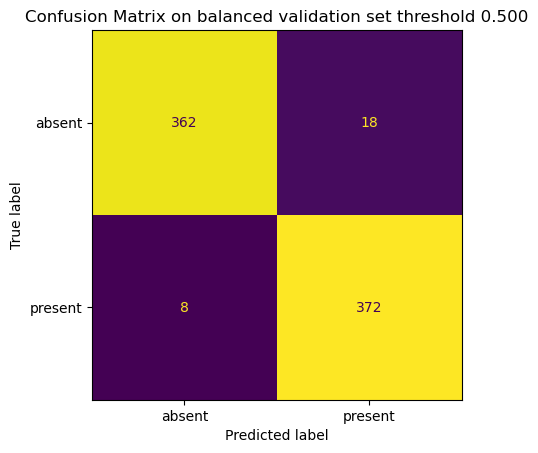

In [58]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(balanced_valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion Matrix on balanced validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Look at the metrics across thresholds
for the balanced validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


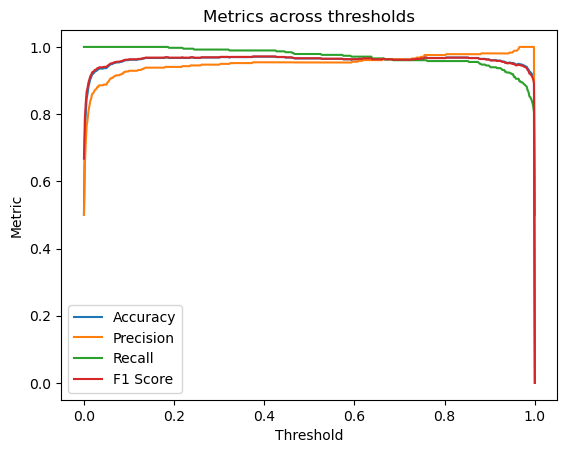

In [59]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [60]:
cm

array([[362,  18],
       [  8, 372]])

In [61]:
# log confusion matrix to wandb as a table
wandb.log({"validation.confusion_matrix": cm})


In [62]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Make predictions and plot confusion matrix on the full validation set
During training we only looked at a subset of the validation set values. 

In [63]:
scores_df = model.predict(valid_df, activation_layer='sigmoid')


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10334 [00:00<?, ?it/s]

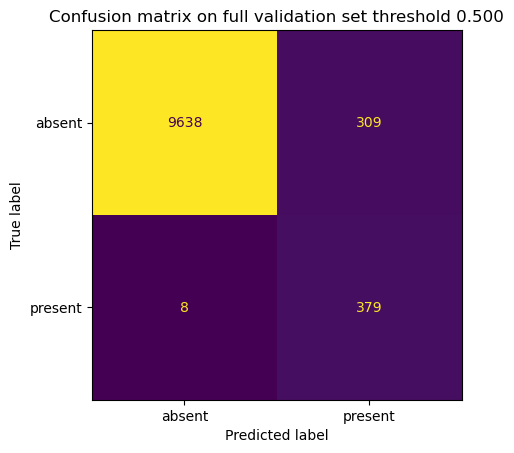

In [64]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Interactive confusion matrix


In [65]:
import ipywidgets as widgets
def show_cm(threshold):
    # Calculate the confusion matrix
    binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
    cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.4f}")
    cm_display.plot(ax=ax, colorbar=False)

from ipywidgets import interact
interact(show_cm, threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.0001, value=0.5))
# show_cm(0.5)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

<function __main__.show_cm(threshold)>

# Look at the metrics across thresholds
for the full validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


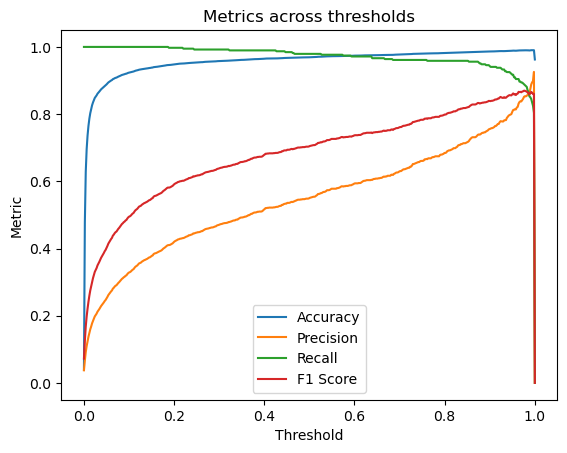

In [66]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

log_single_metric(accuracies, "accuracy_full_set")
log_single_metric(precisions, "precision_full_set")
log_single_metric(recalls, "recall_full_set")
log_single_metric(f1s, "f1_full_set")

# Result: 
Training on 1700 from each class produces a model with high precision and recall. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check. There you can load a pretrained model, make predictions on the validation set, and look at predictions in order of highest error for each class. 

# Save the best model to disk


In [67]:
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"{wandb.run.name}efficientnet_1971_1700_3942.model")

In [68]:
train_df.value_counts()


target_presence
0.0                3942
1.0                3743
Name: count, dtype: int64

In [69]:
wandb.finish()

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore
